# PROJECT SETUP & ENVIRONMENT

In [86]:
#   Install Libraries
!pip install torch torchvision torchaudio --quiet
!pip install transformers datasets --quiet
!pip install scikit-learn xgboost lightgbm imbalanced-learn --quiet
!pip install pandas numpy matplotlib seaborn plotly --quiet
!pip install wordcloud shap lime --quiet


In [87]:
#   Import Libraries

# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# NLP & Transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, BertTokenizerFast, DistilBertTokenizerFast, DistilBertForSequenceClassification
from datasets import load_dataset, Dataset as HFDataset, ClassLabel

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


# Handling imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Explainability
import shap
import lime
from lime.lime_text import LimeTextExplainer

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter
from nltk.corpus import stopwords

# System & warnings
import warnings
import os
warnings.filterwarnings("ignore")

# Torch specific
from torch import nn
import accelerate


print(" All libraries imported successfully!")

 All libraries imported successfully!


#  DATA LOADING

In [88]:
from datasets import load_dataset

ds = load_dataset("KunalEsM/bank_complaint_classifier")

# DATA OVERVIEW & EXPLORATION

In [89]:
df = ds['train'].to_pandas()

# Basic info
print(" Dataset Shape:", df.shape)
print("\n First 5 rows:")
display(df.head())

 Dataset Shape: (6957, 2)

 First 5 rows:


Text  \
0  I noticed a deduction of Rs. 750 from my accou...   
1  An amount of Rs. 500 was debited from my savin...   
2  My account was charged Rs. 300 as ATM fees on ...   
3  I am writing to report an unauthorized charge ...   
4  I received a notification that Rs. 1000 was de...   

                                               label  
0  DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute i...  
1  DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute i...  
2  DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute i...  
3  DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute i...  
4  DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute i...

In [90]:
print("\n Column Names & Data Types:")
print(df.info())


 Column Names & Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6957 entries, 0 to 6956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    6957 non-null   object
 1   label   6957 non-null   object
dtypes: object(2)
memory usage: 108.8+ KB
None


In [91]:
print("\n Summary Statistics (numerical features):")
display(df.describe())


 Summary Statistics (numerical features):


Text  \
count                                                6957   
unique                                               6838   
top     I have noticed a charge of Rs. 500 deducted fr...   
freq                                                    5   

                                                    label  
count                                                6957  
unique                                                 12  
top     DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC...  
freq                                                  792

In [92]:
# Check for missing values
print("\n Missing Values per Column:")
print(df.isnull().sum())


 Missing Values per Column:
Text     0
label    0
dtype: int64


In [93]:
# Check unique values in each column
print("\n Unique Values per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


 Unique Values per Column:
Text: 6838 unique values
label: 12 unique values



 Target Variable Distribution:
label
DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges                                                                       792
LOANS & ADVANCES-Home loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)           745
LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)      643
LOANS & ADVANCES-Personal loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)       635
LOANS & ADVANCES-Govt Scheme loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)    613
DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related                                                         585
LOANS & ADVANCES-OTHER ADVANCES-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)       581
LOANS & ADVANCES-VEHICLE LOANS-Discrepancy in Charges (Proc

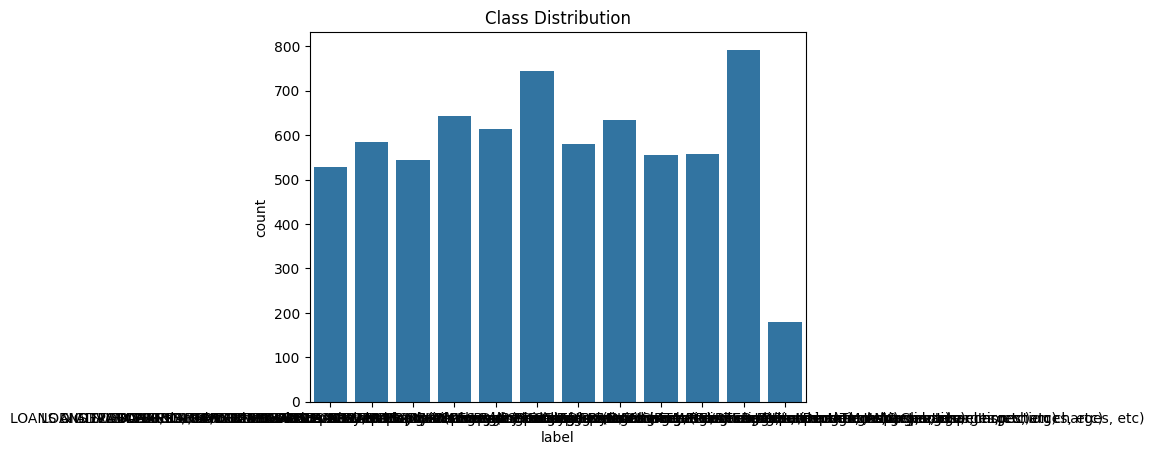

In [94]:
# Target variable distribution
if 'label' in df.columns:
    print("\n Target Variable Distribution:")
    print(df['label'].value_counts())
    sns.countplot(data=df, x='label')
    plt.title("Class Distribution")
    plt.show()

# Exploratory Data Analysis (EDA)



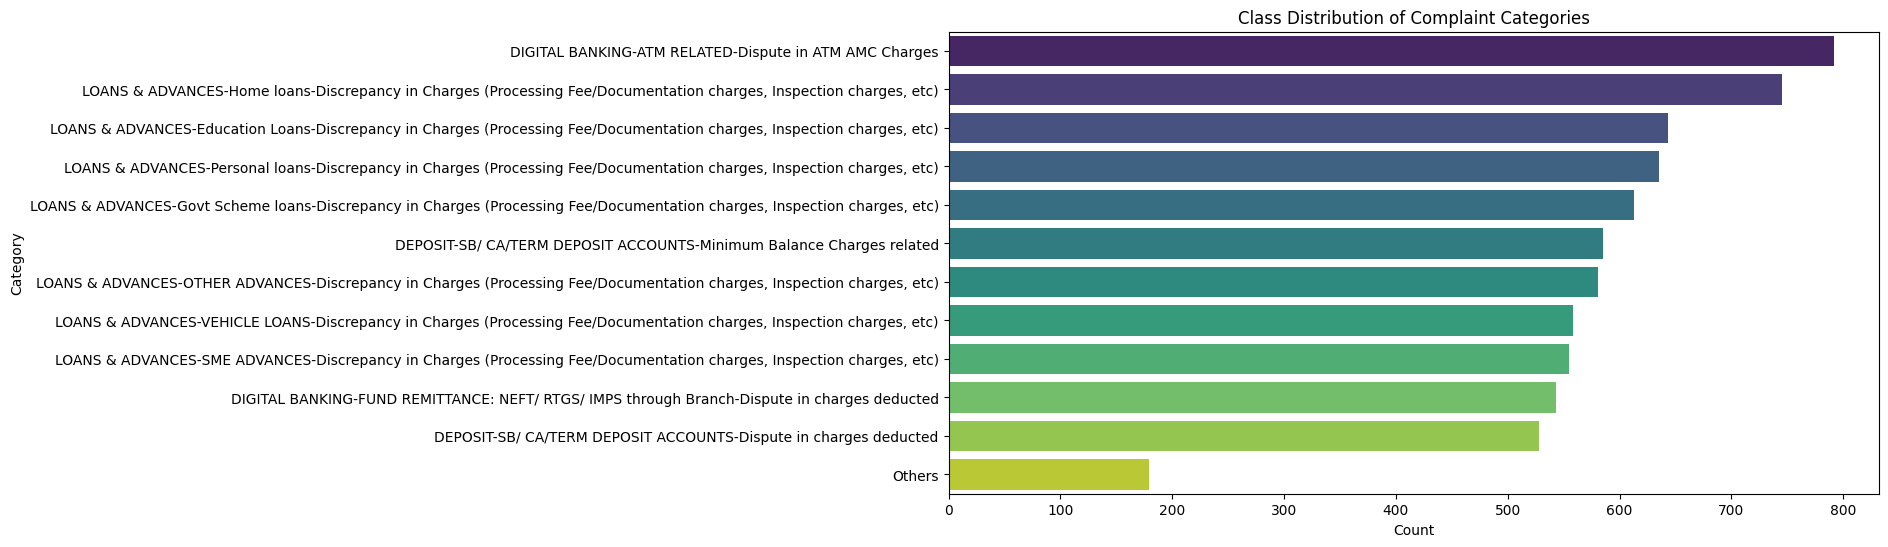

In [95]:
# 1 Class Distribution (Bar Plot)
plt.figure(figsize=(12,6))
sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette="viridis")
plt.title("Class Distribution of Complaint Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

In [96]:
# 2 Class Distribution (Interactive Plotly Pie Chart)
fig = px.pie(df, names="label", title="Category Distribution (Interactive Pie)")
fig.show()

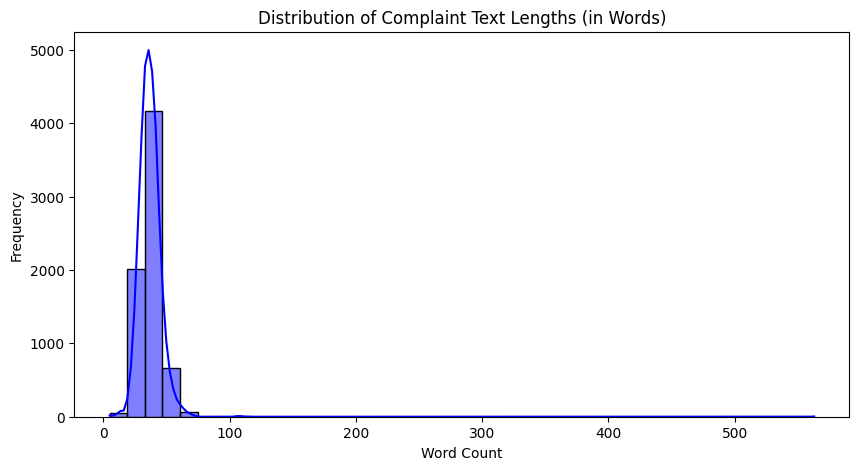

In [97]:
# 3 Complaint Length Distribution (Words)
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=40, kde=True, color="blue")
plt.title("Distribution of Complaint Text Lengths (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

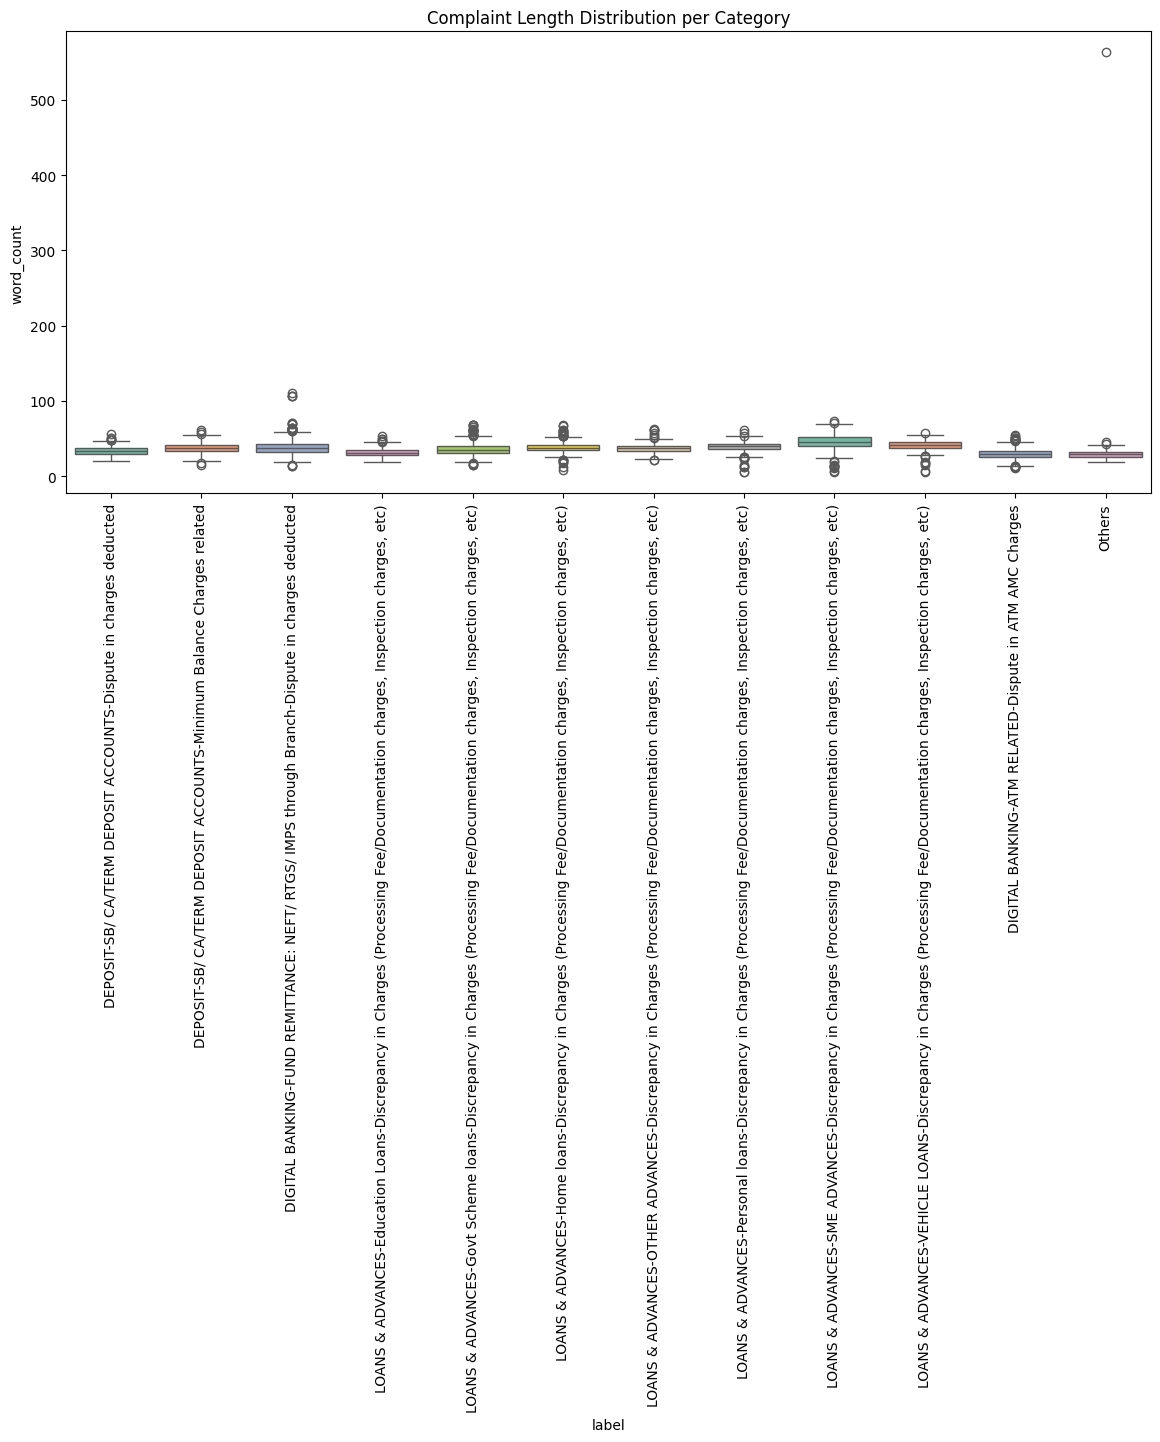

In [98]:
# 4 Complaint Length by Category (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='label', y='word_count', palette="Set2")
plt.xticks(rotation=90)
plt.title("Complaint Length Distribution per Category")
plt.show()

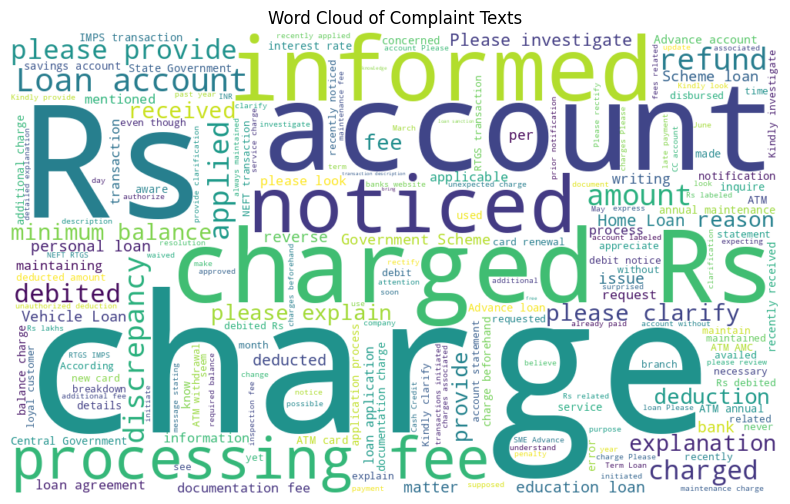

In [99]:
# 5 Word Cloud for All Complaints
all_text = " ".join(df['Text'].astype(str))
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis').generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Complaint Texts")
plt.show()

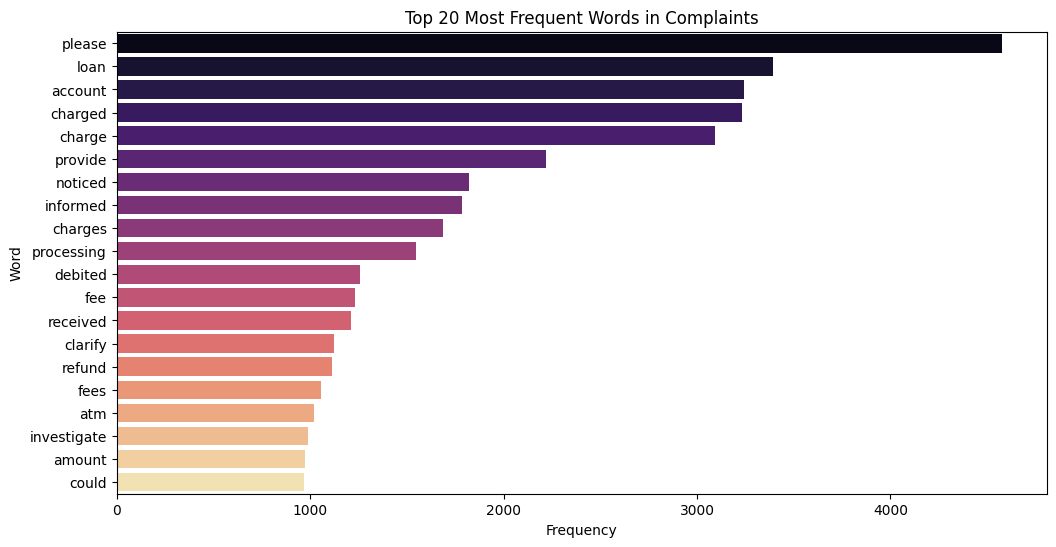

In [100]:
# 6 Top 20 Most Frequent Words
stop_words = set(stopwords.words('english'))
all_words = " ".join(df['Text']).lower().split()
filtered_words = [word for word in all_words if word.isalpha() and word not in stop_words]
word_freq = Counter(filtered_words).most_common(20)

plt.figure(figsize=(12,6))
sns.barplot(x=[x[1] for x in word_freq], y=[x[0] for x in word_freq], palette="magma")
plt.title("Top 20 Most Frequent Words in Complaints")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

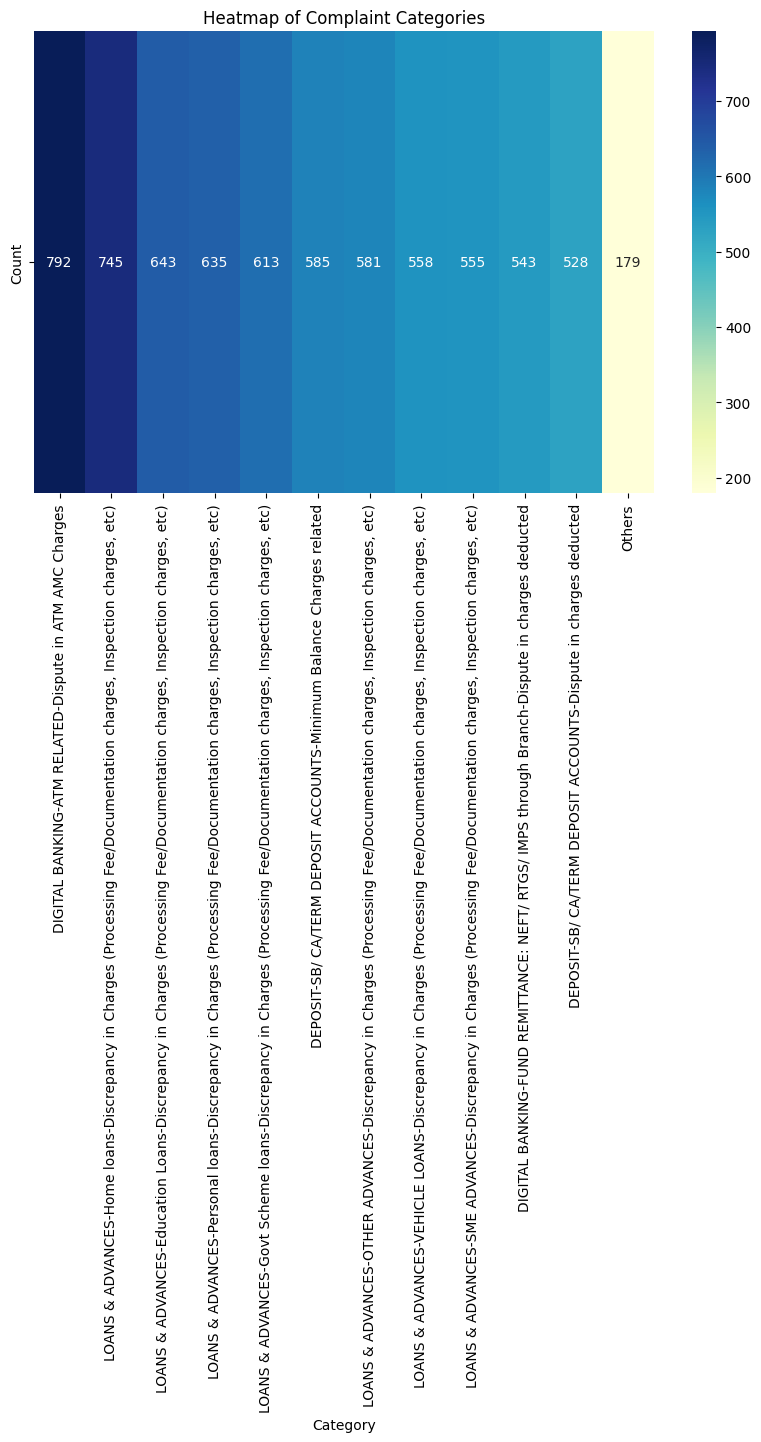

In [101]:
# 7 Heatmap of Category Frequencies (Cross-tab of counts)
category_counts = df['label'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10,6))
sns.heatmap(category_counts.set_index('Category').T, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Heatmap of Complaint Categories")
plt.show()

# TEXT PREPROCESSING & SENTIMENT ANALYSIS

In [102]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Apply sentiment scoring
df['sentiment_score'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(
    lambda score: 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral')
)

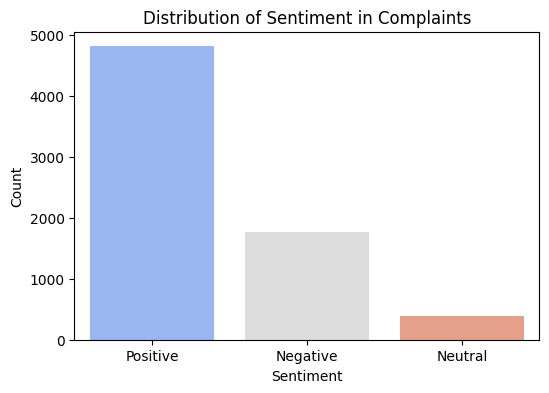

In [103]:
# 8 Distribution of Sentiment Labels
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment_label'], palette="coolwarm")
plt.title("Distribution of Sentiment in Complaints")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

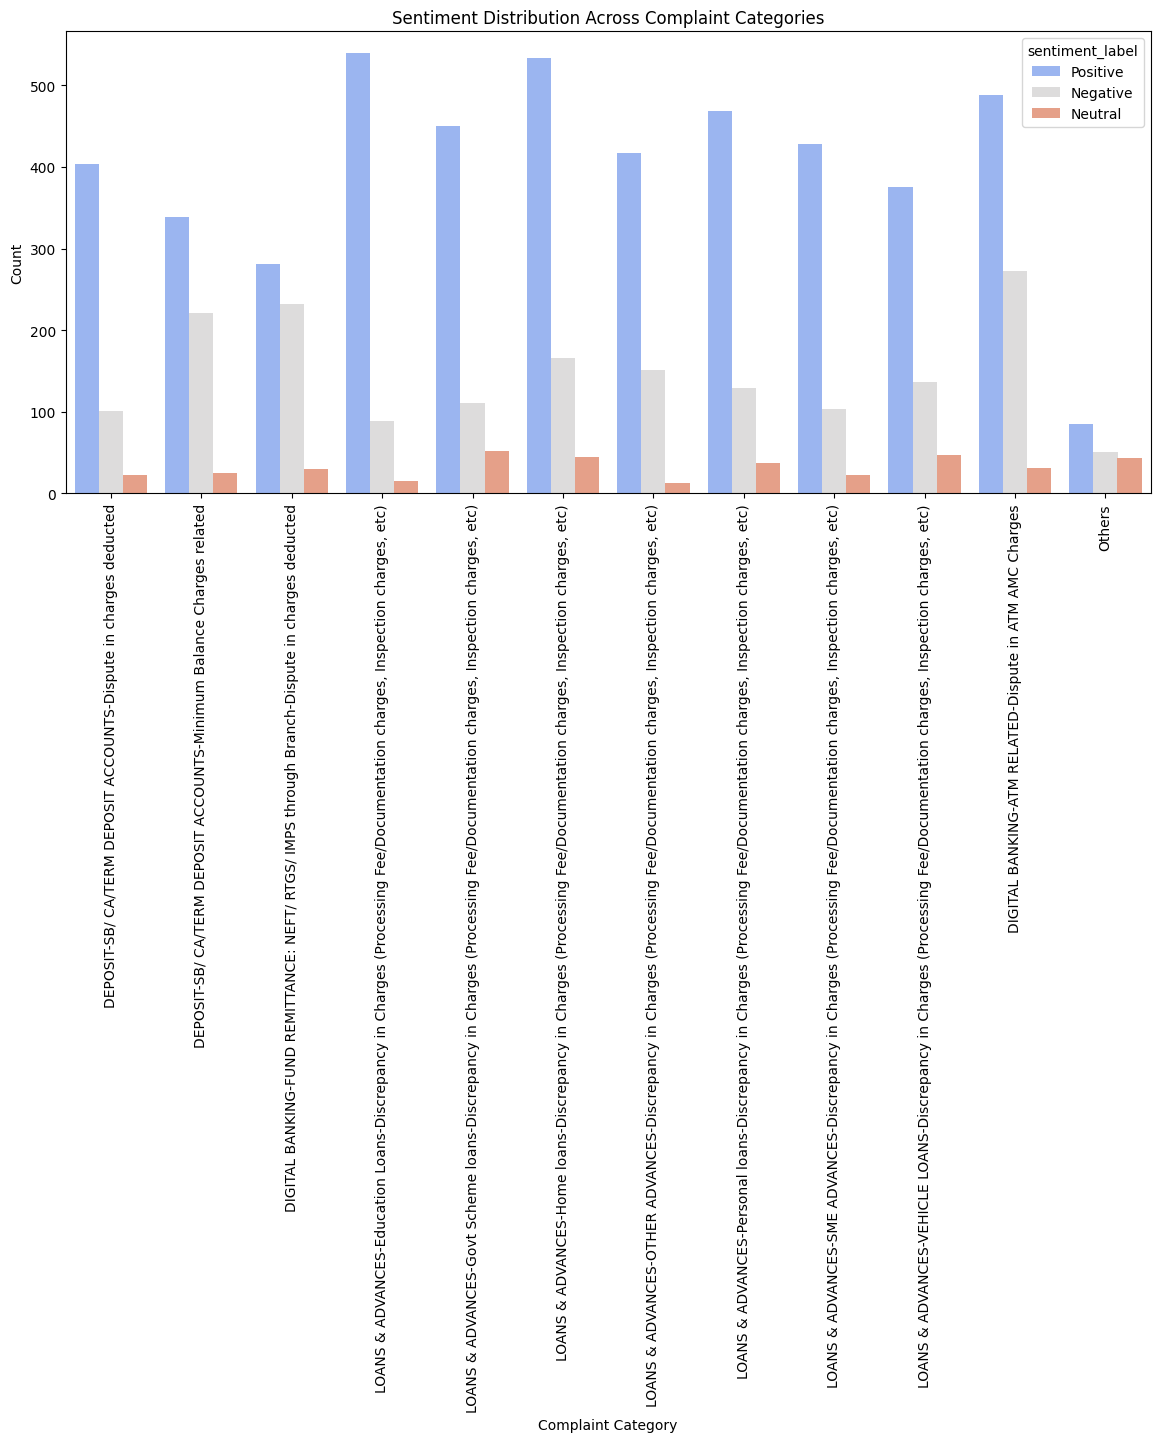

In [104]:
# 9 Sentiment Distribution Across Categories
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="label", hue="sentiment_label", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Sentiment Distribution Across Complaint Categories")
plt.xlabel("Complaint Category")
plt.ylabel("Count")
plt.show()

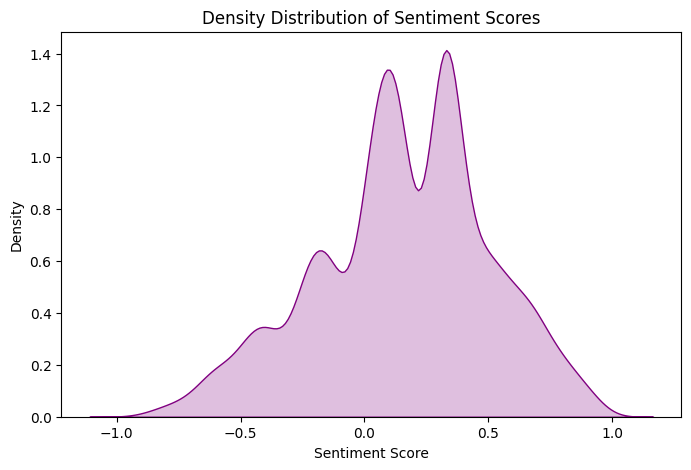

In [105]:
# 10 Sentiment Score Density Plot
plt.figure(figsize=(8,5))
sns.kdeplot(df['sentiment_score'], shade=True, color="purple")
plt.title("Density Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.show()

# Baseline Models


 Training Logistic Regression...

 Logistic Regression Accuracy: 0.9864

                                                                                                                           precision    recall  f1-score   support

                                                         DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute in charges deducted       0.90      0.93      0.92       105
                                                     DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related       0.98      0.96      0.97       117
                                                                   DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges       0.98      1.00      0.99       158
                             DIGITAL BANKING-FUND REMITTANCE: NEFT/ RTGS/ IMPS through Branch-Dispute in charges deducted       0.98      0.99      0.99       109
  LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection ch

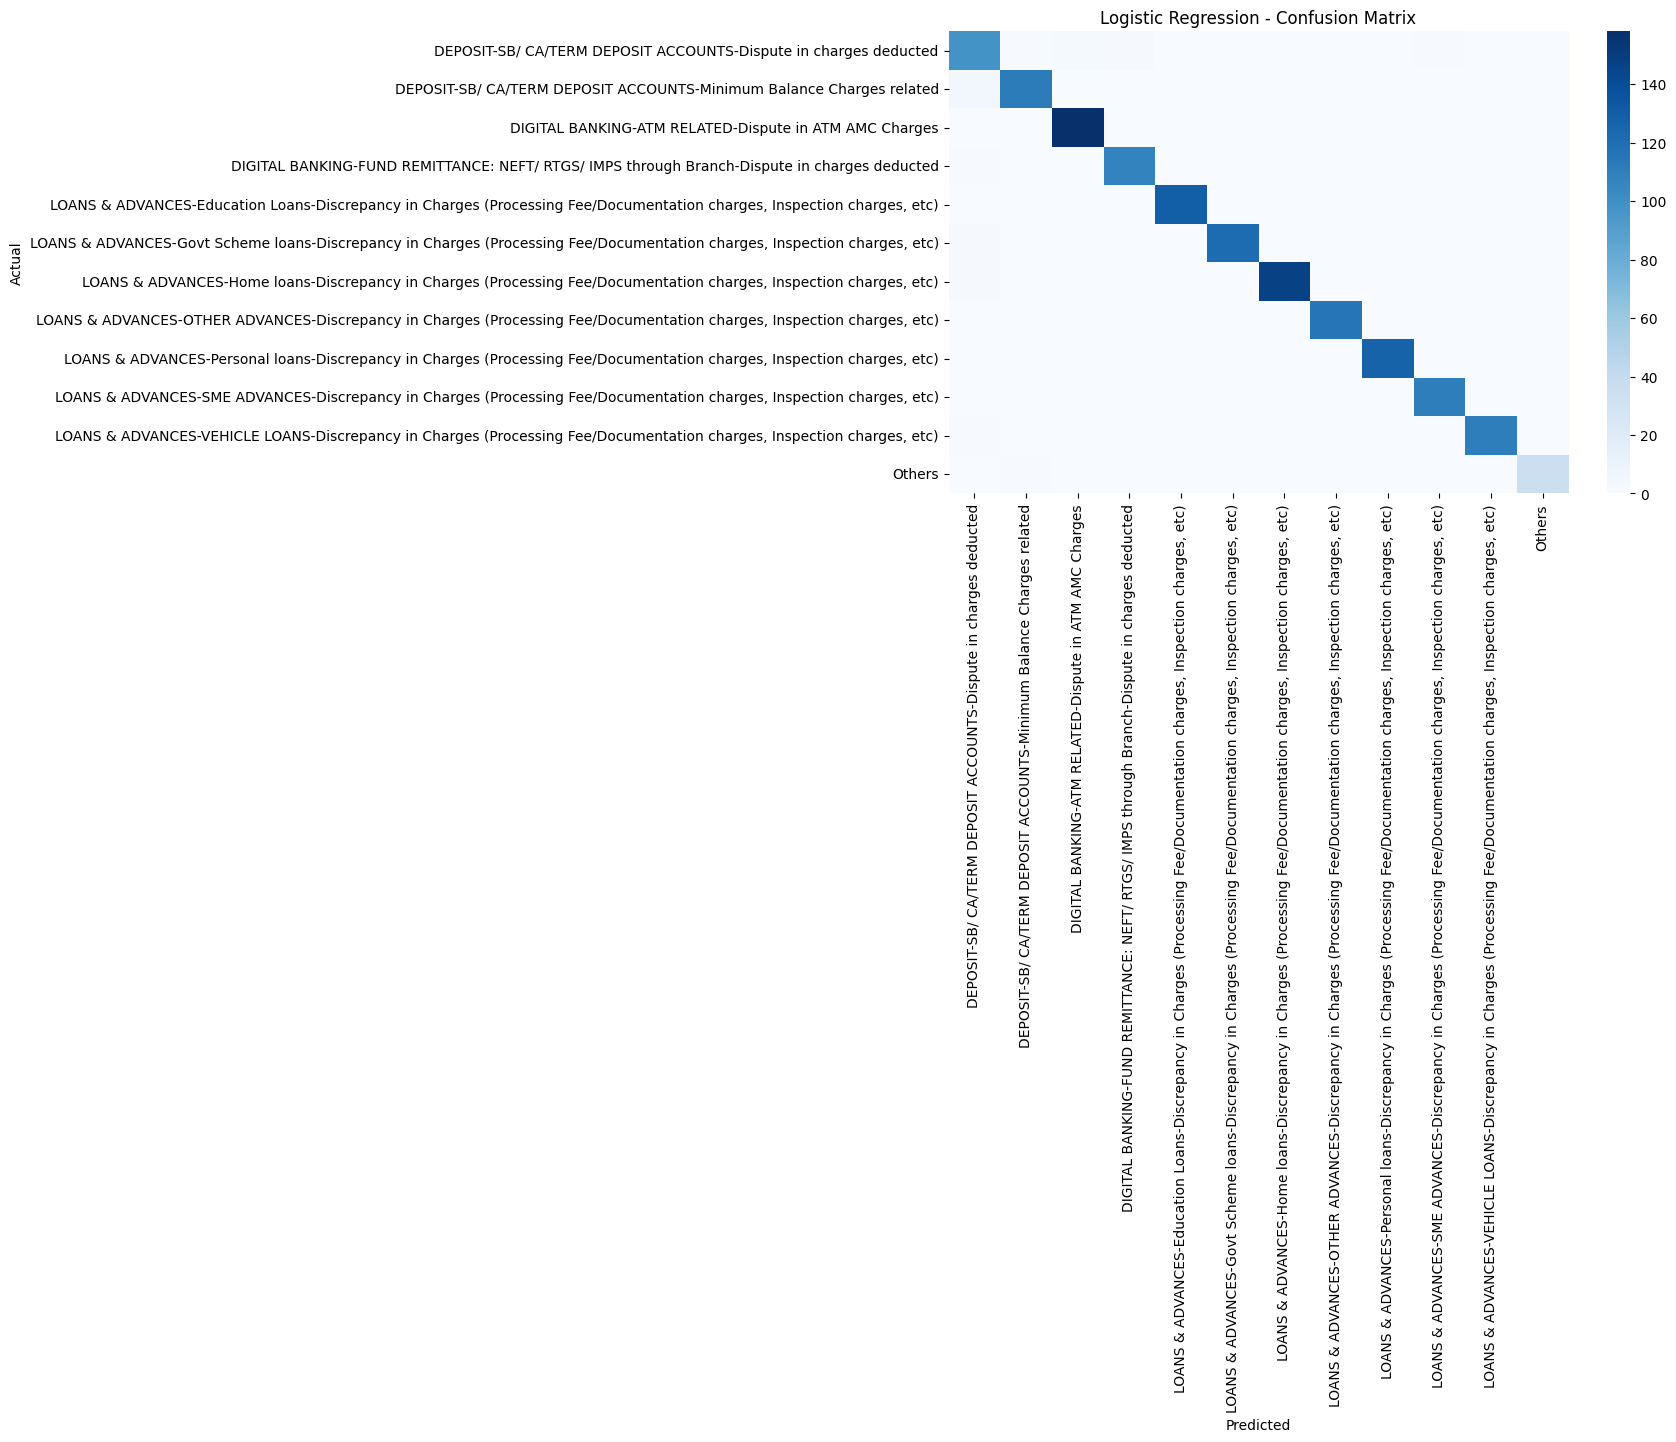

In [106]:
# Baseline Models: Logistic Regression


X = df["Text"]
y = df["label"]


# 3. Define Model
name = "Logistic Regression"
model = LogisticRegression(max_iter=500, class_weight="balanced")

# 4. Train & Evaluate
print(f"\n Training {name}...")
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"\n {name} Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

# Save results
results[name] = acc

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title(f"{name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 Training SVM (LinearSVC)...

 SVM (LinearSVC) Accuracy: 0.9907

                                                                                                                           precision    recall  f1-score   support

                                                         DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute in charges deducted       0.95      0.94      0.95       105
                                                     DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related       0.98      0.97      0.97       117
                                                                   DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges       0.99      1.00      0.99       158
                             DIGITAL BANKING-FUND REMITTANCE: NEFT/ RTGS/ IMPS through Branch-Dispute in charges deducted       0.97      1.00      0.99       109
  LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, e

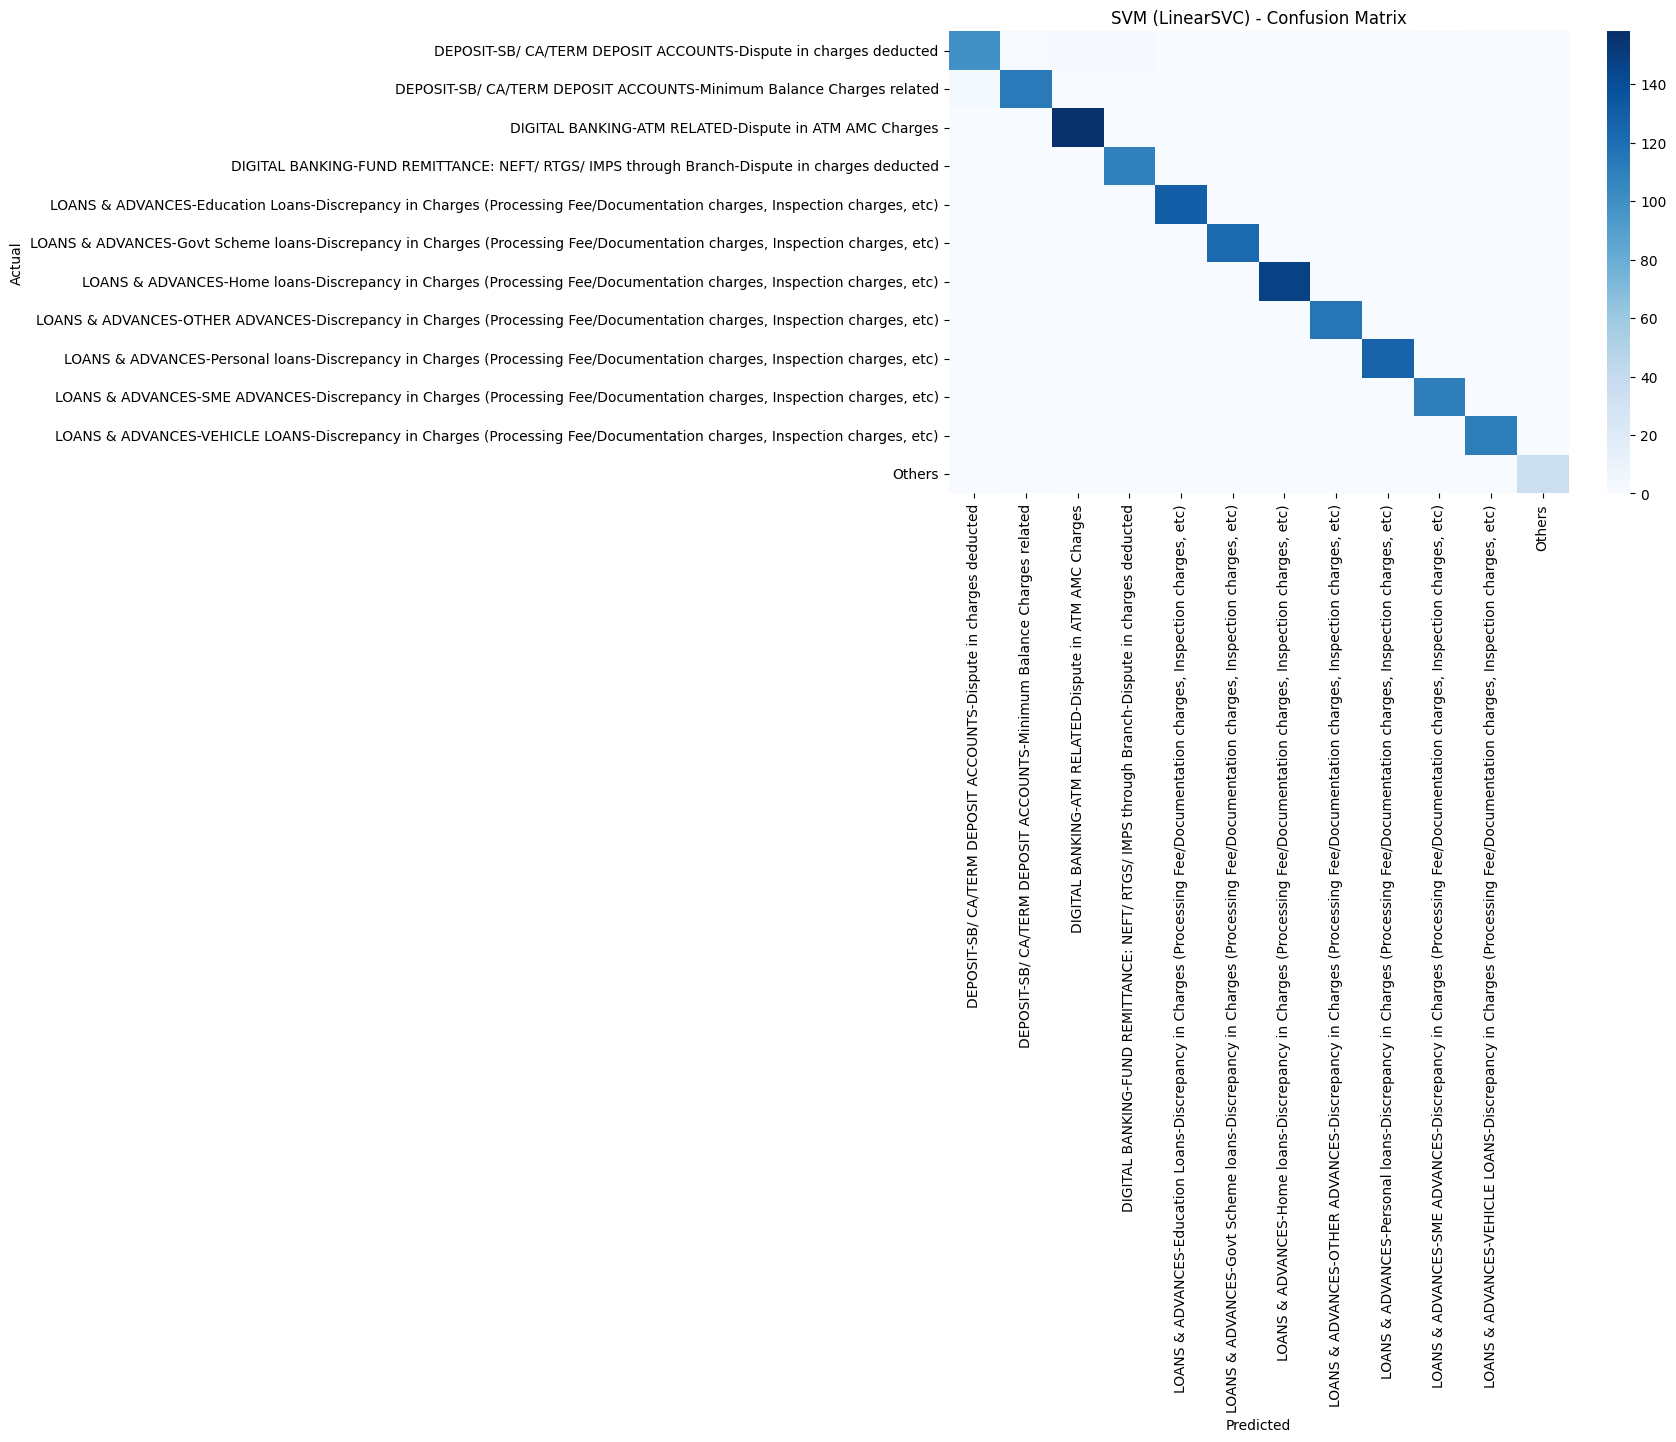

In [107]:
# Baseline Models: SVM (LinearSVC)


X = df["Text"]
y = df["label"]


# 3. Define Model
name = "SVM (LinearSVC)"
model = LinearSVC(class_weight="balanced")

# 4. Train & Evaluate
print(f"\n Training {name}...")
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"\n {name} Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

# Save results
results[name] = acc

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title(f"{name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 Training Random Forest...

 Random Forest Accuracy: 0.9849

                                                                                                                           precision    recall  f1-score   support

                                                         DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute in charges deducted       0.88      0.94      0.91       105
                                                     DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related       0.99      0.95      0.97       117
                                                                   DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges       0.98      1.00      0.99       158
                             DIGITAL BANKING-FUND REMITTANCE: NEFT/ RTGS/ IMPS through Branch-Dispute in charges deducted       0.99      0.99      0.99       109
  LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc) 

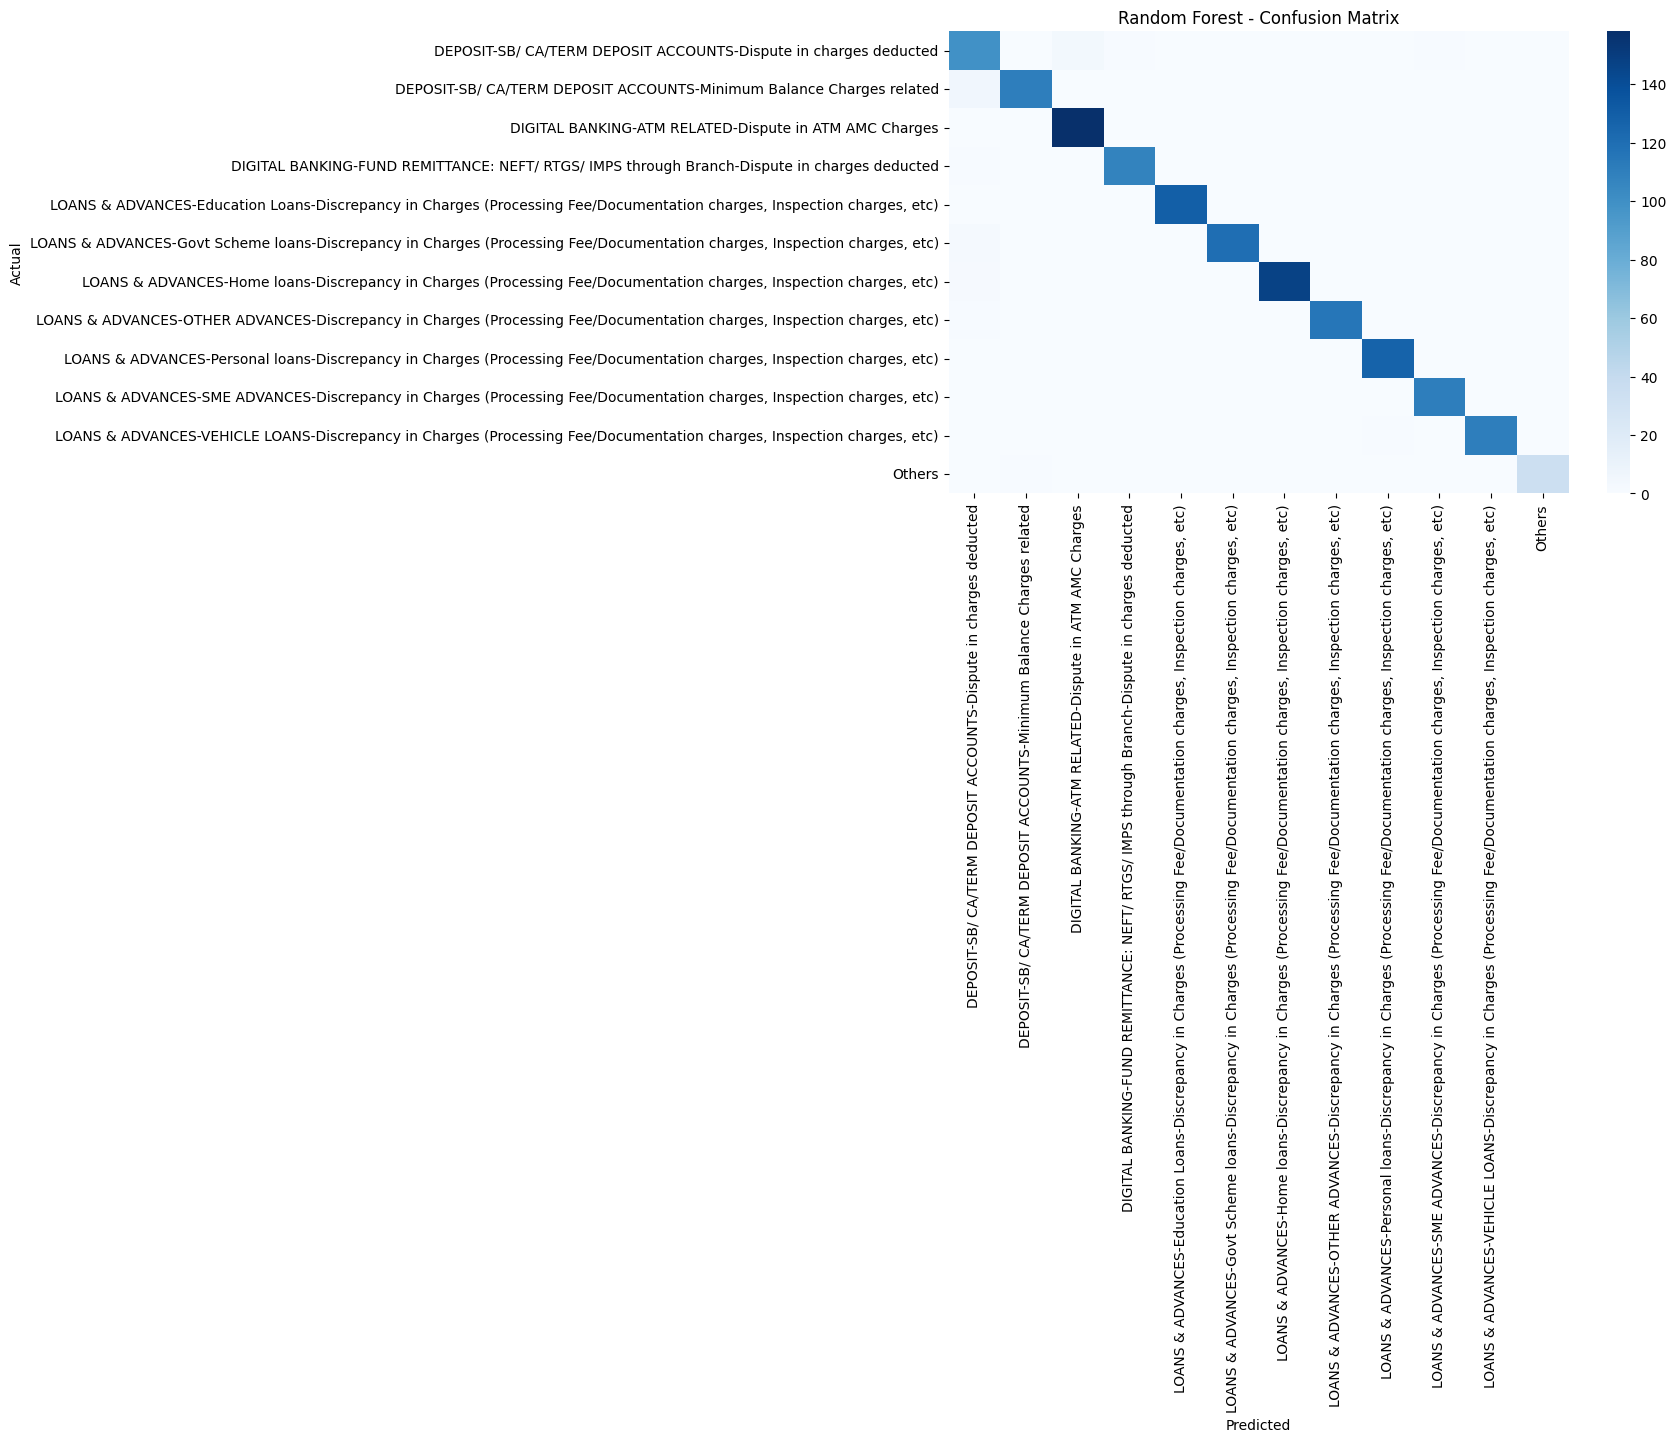

In [108]:
# Baseline Models: Random Forest


X = df["Text"]
y = df["label"]


# 3. Define Model
name = "Random Forest"
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# 4. Train & Evaluate
print(f"\n Training {name}...")
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"\n {name} Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

# Save results
results[name] = acc

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title(f"{name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Deep Learning Models

# BERT

In [109]:
print(" Libraries ready. CUDA available:", torch.cuda.is_available())

 Libraries ready. CUDA available: True


In [110]:
# Encode target labels
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["label"])
num_labels = len(label_encoder.classes_)

print("Classes:", label_encoder.classes_)
print("Number of labels:", num_labels)


Classes: ['DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute in charges deducted'
 'DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related'
 'DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges'
 'DIGITAL BANKING-FUND REMITTANCE: NEFT/ RTGS/ IMPS through Branch-Dispute in charges deducted'
 'LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Govt Scheme loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Home loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-OTHER ADVANCES-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Personal loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-SME ADVANCES-Discrepancy in Charges (Processing Fee/Documentation ch

In [111]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=128)


In [112]:
dataset = HFDataset.from_pandas(df[["Text", "label_enc"]])
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label_enc", "labels")

# Cast labels to ClassLabel
features = dataset.features
features['labels'] = ClassLabel(num_classes=num_labels, names=label_encoder.classes_.tolist())
dataset = dataset.cast(features)

dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Train-test split
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="labels", seed=42)
train_dataset, test_dataset = dataset["train"], dataset["test"]

print(train_dataset, test_dataset)


Map:   0%|          | 0/6957 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6957 [00:00<?, ? examples/s]

Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5565
}) Dataset({
    features: ['Text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1392
})


In [113]:
class_counts = df["label_enc"].value_counts().sort_index().values
class_weights = torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.sum() / (len(class_weights) * class_weights)

print("Class Weights:", class_weights)


Class Weights: tensor([1.0980, 0.9910, 0.7320, 1.0677, 0.9016, 0.9458, 0.7782, 0.9978, 0.9130,
        1.0446, 1.0390, 3.2388])


In [114]:
class WeightedBERT(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits}

# Load pretrained BERT
model = WeightedBERT.from_pretrained(model_name, num_labels=num_labels)
model.class_weights = class_weights
model.num_labels = num_labels


Some weights of WeightedBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1, "precision": precision, "recall": recall}


In [116]:
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_total_limit=0,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=False,
    report_to='none'
)

print(" Training args ready")

 Training args ready


In [117]:
import os
os.environ["WANDB_DISABLED"] = "true"
from accelerate import Accelerator

accelerator = Accelerator()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [118]:
trainer.train()

TrainOutput(global_step=1044, training_loss=0.240088631737963, metrics={'train_runtime': 443.6657, 'train_samples_per_second': 37.63, 'train_steps_per_second': 2.353, 'total_flos': 1098258366643200.0, 'train_loss': 0.240088631737963, 'epoch': 3.0})

In [119]:
results = trainer.evaluate()
print(" BERT Evaluation:", results)


 BERT Evaluation: {'eval_loss': 0.048757679760456085, 'eval_accuracy': 0.9899425287356322, 'eval_macro_f1': 0.9899996606320499, 'eval_precision': 0.9902536837316243, 'eval_recall': 0.9898219289544943, 'eval_runtime': 9.1052, 'eval_samples_per_second': 152.88, 'eval_steps_per_second': 4.832, 'epoch': 3.0}


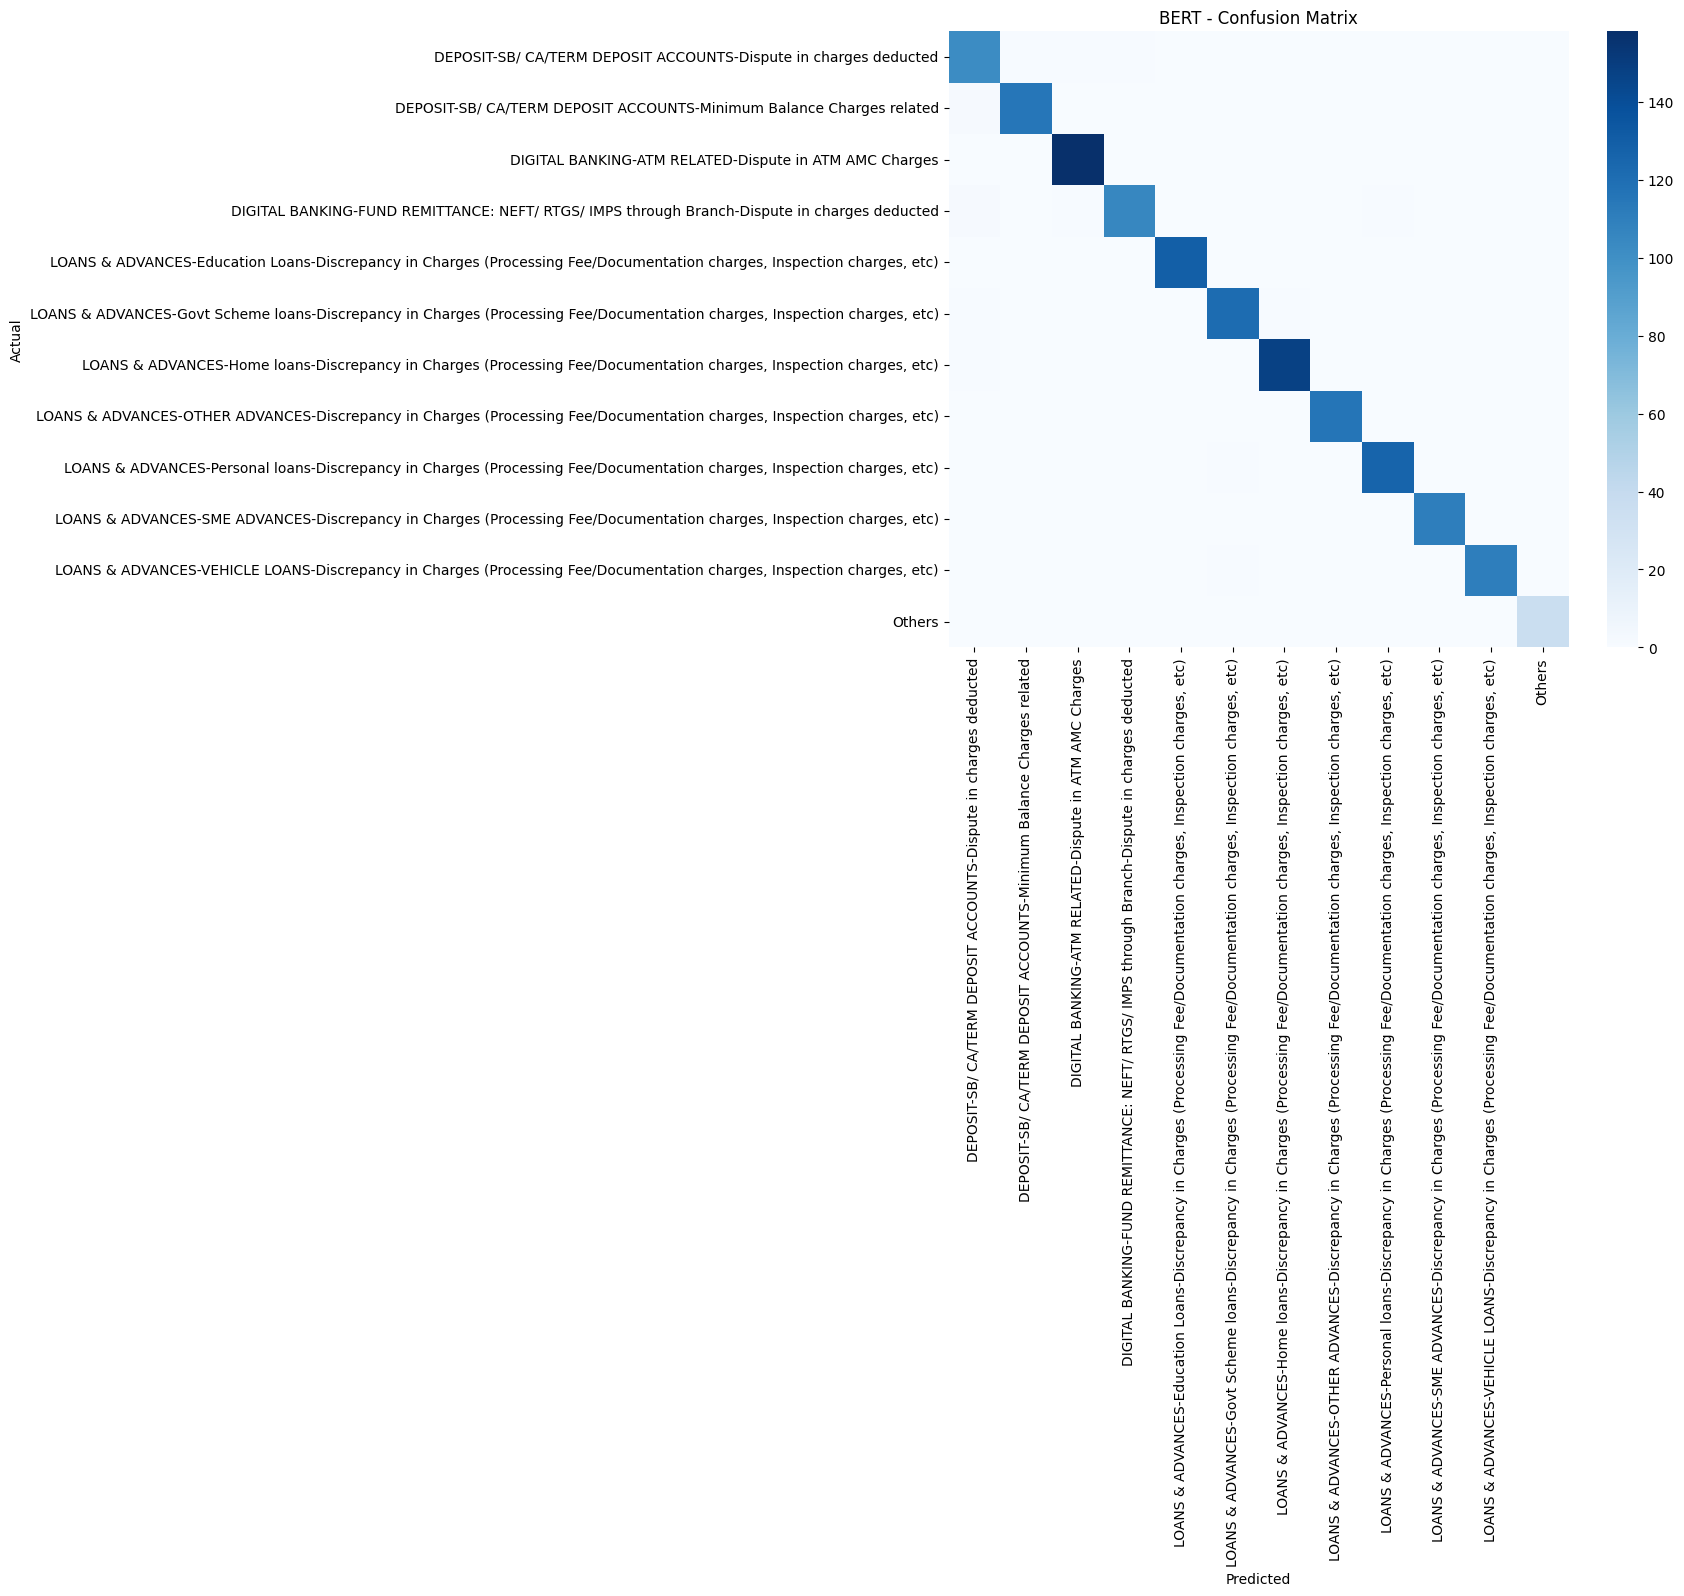

In [120]:
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(num_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("BERT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# DISTILBERT

In [121]:
print(" Imports ready")

 Imports ready


In [122]:
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["label"])
num_labels = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=128)


Classes: ['DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Dispute in charges deducted'
 'DEPOSIT-SB/ CA/TERM DEPOSIT ACCOUNTS-Minimum Balance Charges related'
 'DIGITAL BANKING-ATM RELATED-Dispute in ATM AMC Charges'
 'DIGITAL BANKING-FUND REMITTANCE: NEFT/ RTGS/ IMPS through Branch-Dispute in charges deducted'
 'LOANS & ADVANCES-Education Loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Govt Scheme loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Home loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-OTHER ADVANCES-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-Personal loans-Discrepancy in Charges (Processing Fee/Documentation charges, Inspection charges, etc)'
 'LOANS & ADVANCES-SME ADVANCES-Discrepancy in Charges (Processing Fee/Documentation ch

In [123]:
# Hugging Face Dataset
dataset = HFDataset.from_pandas(df[["Text", "label_enc"]])
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label_enc", "labels")

# Cast labels
features = dataset.features
features["labels"] = ClassLabel(num_classes=num_labels, names=label_encoder.classes_.tolist())
dataset = dataset.cast(features)

dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Train-test split
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="labels", seed=42)
train_dataset, test_dataset = dataset["train"], dataset["test"]

print(" Dataset ready:", train_dataset, test_dataset)

Map:   0%|          | 0/6957 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6957 [00:00<?, ? examples/s]

 Dataset ready: Dataset({
    features: ['Text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 5565
}) Dataset({
    features: ['Text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1392
})


In [124]:
class WeightedDistilBERT(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits}

# Compute weights
class_counts = df["label_enc"].value_counts().sort_index().values
class_weights = torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.sum() / (len(class_weights) * class_weights)

print("Class Weights:", class_weights)

# Load model
model = WeightedDistilBERT.from_pretrained(model_name, num_labels=num_labels)
model.class_weights = class_weights


Class Weights: tensor([1.0980, 0.9910, 0.7320, 1.0677, 0.9016, 0.9458, 0.7782, 0.9978, 0.9130,
        1.0446, 1.0390, 3.2388])


Some weights of WeightedDistilBERT were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1, "precision": precision, "recall": recall}


In [126]:
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    eval_strategy="epoch",
    save_total_limit=0,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none"
)

print(" Training args ready")

 Training args ready


In [127]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


TrainOutput(global_step=1044, training_loss=0.22307654370293306, metrics={'train_runtime': 226.6966, 'train_samples_per_second': 73.645, 'train_steps_per_second': 4.605, 'total_flos': 552984404474880.0, 'train_loss': 0.22307654370293306, 'epoch': 3.0})

 DistilBERT Evaluation: {'eval_loss': 0.06118112802505493, 'eval_accuracy': 0.985632183908046, 'eval_macro_f1': 0.9854785876743003, 'eval_precision': 0.9855942651276806, 'eval_recall': 0.9853785241075358, 'eval_runtime': 4.4568, 'eval_samples_per_second': 312.333, 'eval_steps_per_second': 9.873, 'epoch': 3.0}


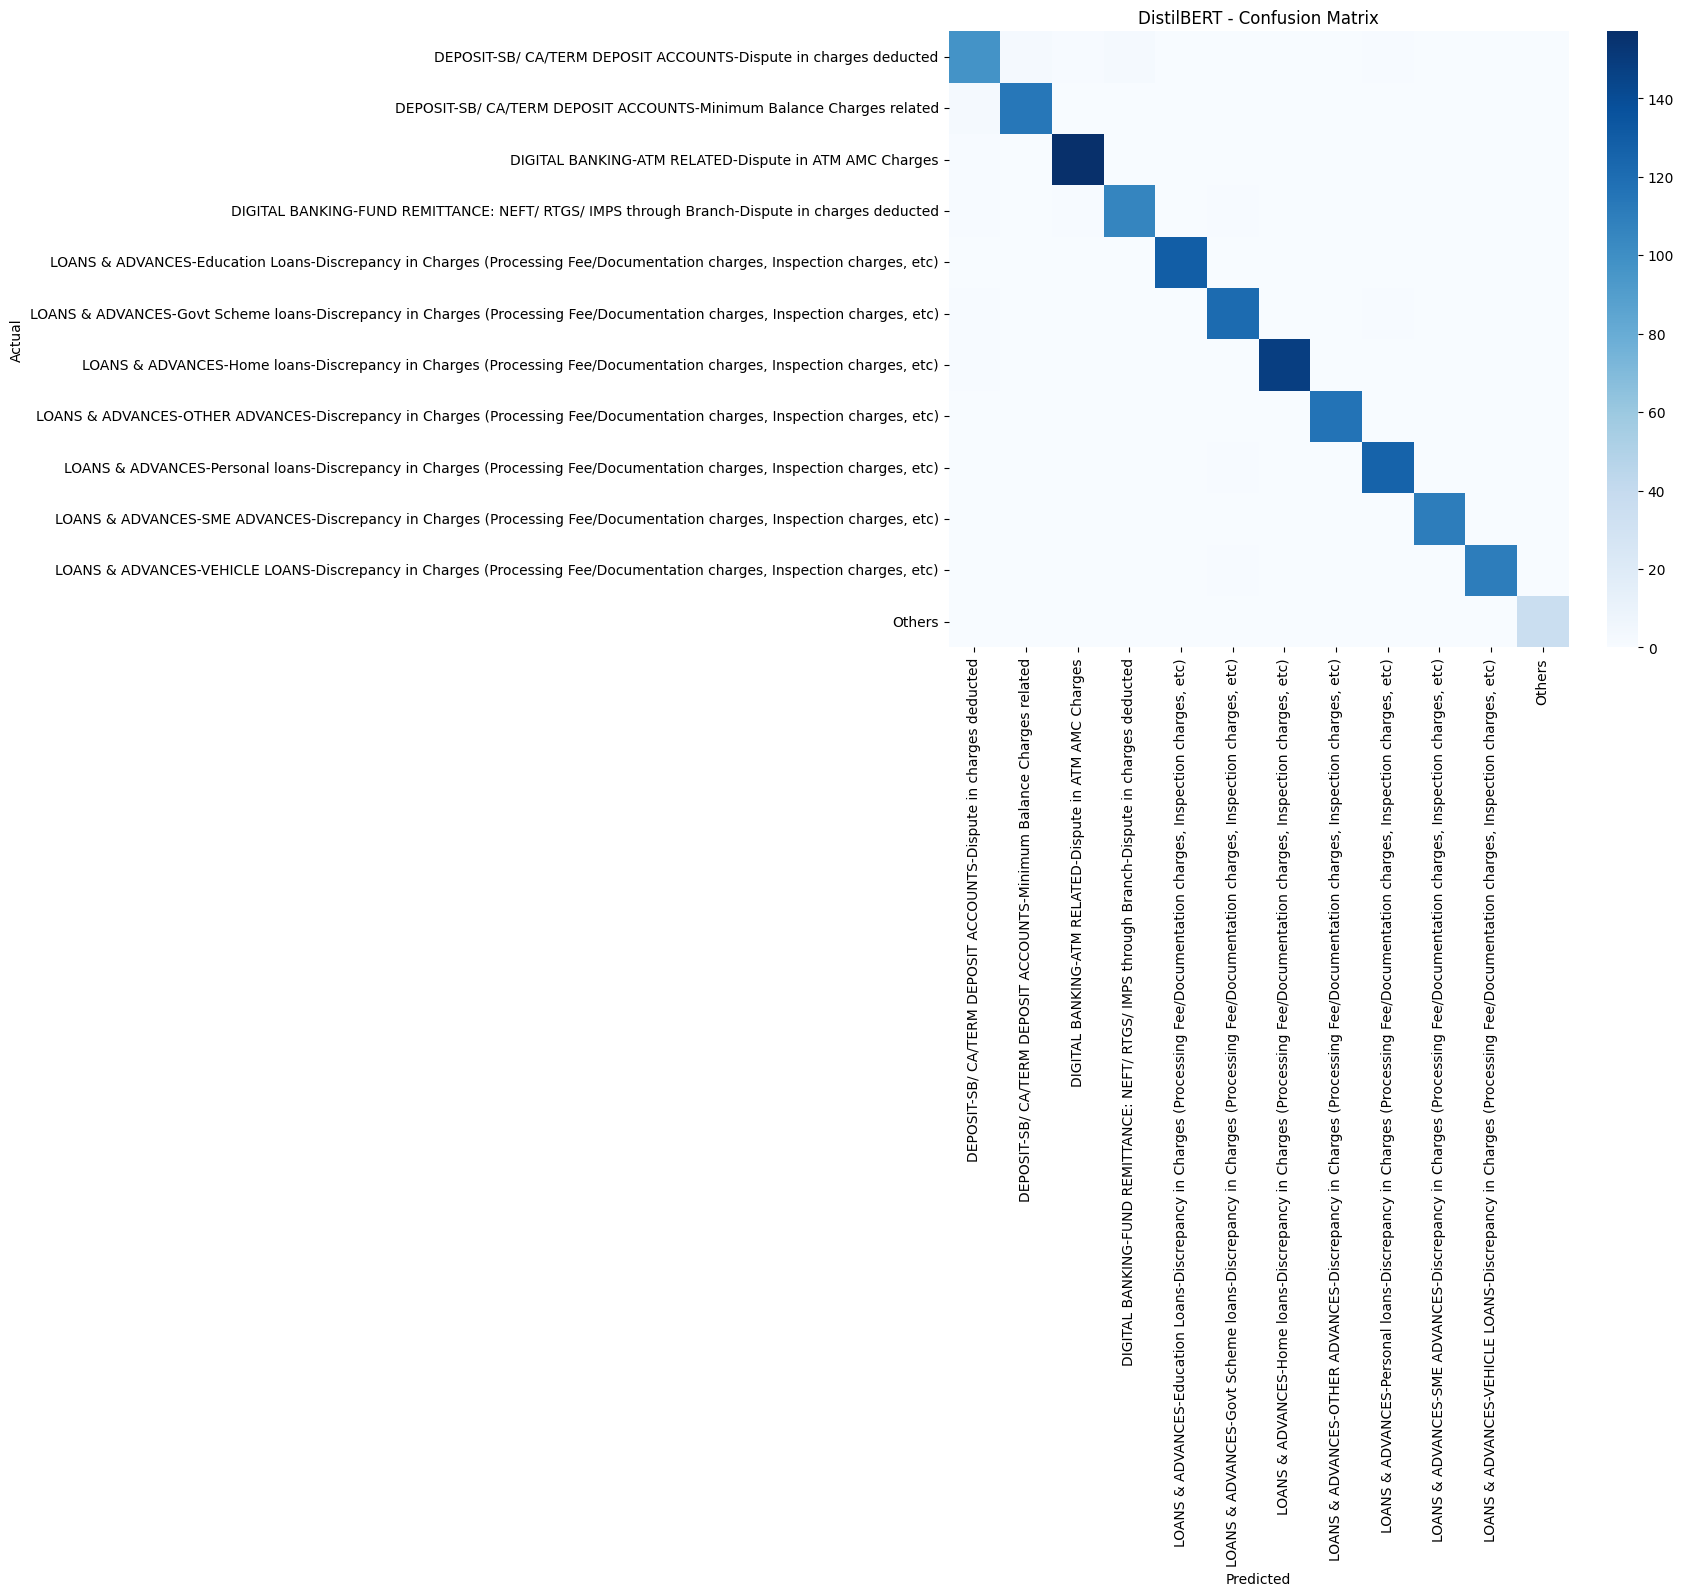

In [128]:
results = trainer.evaluate()
print(" DistilBERT Evaluation:", results)

# Predictions
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(num_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("DistilBERT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Model Evaluation & Comparison

In [129]:


results_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest", "BERT (base)", "DistilBERT"],
    "Accuracy": [0.9864, 0.9907, 0.9849, 0.9871, 0.9856],
    "Macro F1": [0.986, 0.991, 0.985, 0.987, 0.985]
})

display(results_summary)


Model  Accuracy  Macro F1
0  Logistic Regression    0.9864     0.986
1                  SVM    0.9907     0.991
2        Random Forest    0.9849     0.985
3          BERT (base)    0.9871     0.987
4           DistilBERT    0.9856     0.985

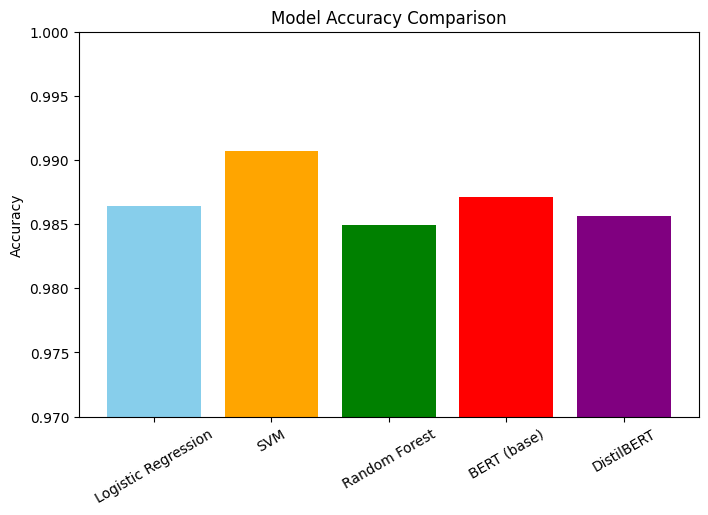

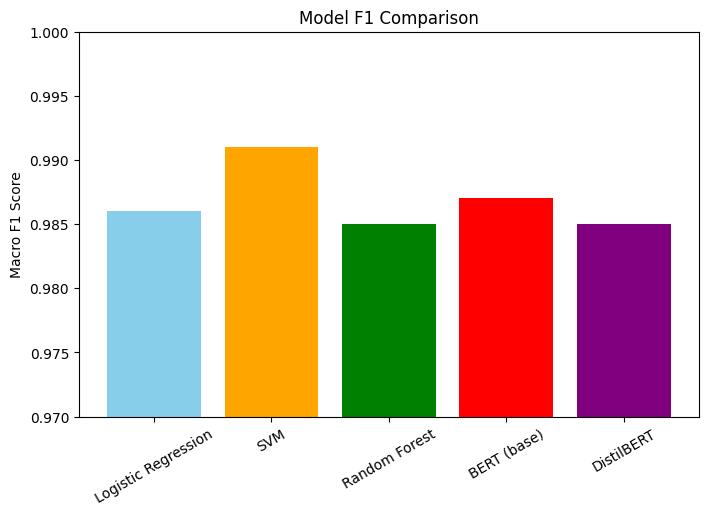

In [130]:
# Accuracy Comparison
plt.figure(figsize=(8,5))
plt.bar(results_summary["Model"], results_summary["Accuracy"], color=["skyblue","orange","green","red","purple"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30)
plt.ylim(0.97, 1.0)
plt.show()

# F1 Score Comparison
plt.figure(figsize=(8,5))
plt.bar(results_summary["Model"], results_summary["Macro F1"], color=["skyblue","orange","green","red","purple"])
plt.ylabel("Macro F1 Score")
plt.title("Model F1 Comparison")
plt.xticks(rotation=30)
plt.ylim(0.97, 1.0)
plt.show()
